In this tutorial, we will show the effects of Fountain corrects batch in original dimensions, enhancing comprehensive cellular characterization. For convenience, here we directly import the [batch-corrected and enhanced MB ATAC profiles](https://drive.google.com/file/d/13nLqv6IC1OzqrgjnRMJ-MvWBFeW6f6Ur/view?usp=drive_link) obtained from this [tutorial](https://github.com/BioX-NKU/Fountain/blob/main/Tutorials/Batch%20correction.ipynb) in the original dimensions. 

In [64]:
import scanpy as sc
import episcanpy as epi
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import scipy
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import anndata as ad
import scanpy.external as sce
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,MaxAbsScaler
from anndata.experimental.pytorch import AnnLoader
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from Fountain.utils import cluster_evaluation
from Fountain.utils import overcorrection_score
import Fountain
from scipy.sparse import csr_matrix
import sklearn  
import os
import scib
import anndata
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import pickle
os.getpid()

1309451

In [65]:
adata = sc.read("MB_enhanced.h5ad")

We claim that the adata.X is the count matrix of raw ATAC profiles and the Fountain-enhanced ATAC profiles are stored in adata.layers \["enhance"\]. See more details in this [tutorial](https://github.com/BioX-NKU/Fountain/blob/main/Tutorials/Batch%20correction.ipynb).

In [28]:
adata

AnnData object with n_obs × n_vars = 13671 × 22320
    obs: 'batch', 'cell_type', 'cell_type_raw', 'test_type', 'leiden'
    var: 'peak', 'n_cells'
    uns: 'leiden', 'neighbors'
    obsm: 'fountain'
    layers: 'enhance'
    obsp: 'connectivities', 'distances'

# UMAP visualizations of the enhanced MB dataset

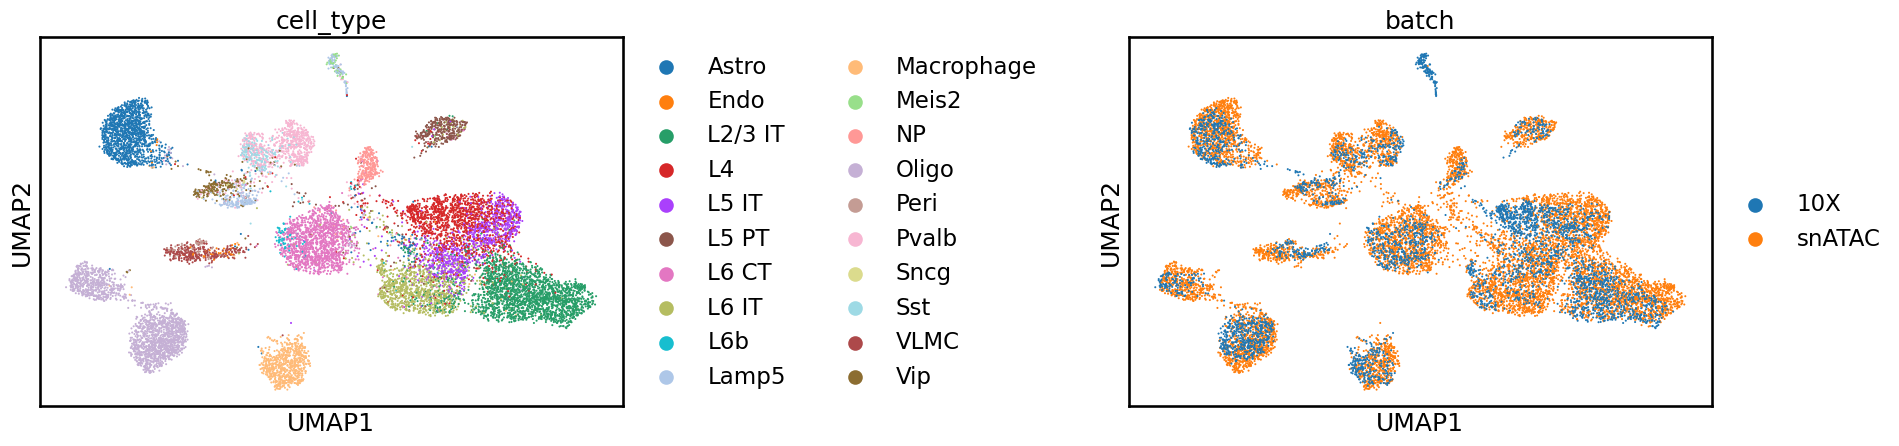

In [29]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep="fountain")
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cell_type','batch'],wspace = 0.7)
epi.tl.leiden(adata, key_added='leiden')

In [66]:
adata_en = adata.copy()
adata_en.X = adata.layers["enhance"]

In [31]:
adata_en

AnnData object with n_obs × n_vars = 13671 × 22320
    obs: 'batch', 'cell_type', 'cell_type_raw', 'test_type', 'leiden'
    var: 'peak', 'n_cells'
    uns: 'leiden', 'neighbors', 'umap', 'cell_type_colors', 'batch_colors'
    obsm: 'fountain', 'X_umap'
    layers: 'enhance'
    obsp: 'connectivities', 'distances'

<Axes: title={'center': 'sequencing depth (log10) of the raw data'}, xlabel='UMAP1', ylabel='UMAP2'>

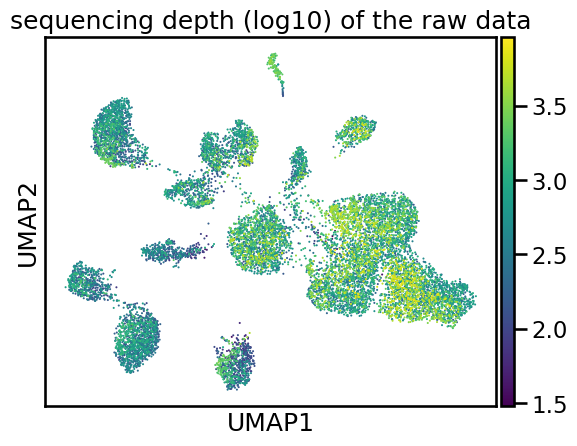

In [32]:
# UMAP visualizations of the enhanced MB dataset. Cells are colored by the sequencing depth of the raw MB dataset.
data = adata.copy()
epi.pp.binarize(data)
count_sum_per_cell = data.X.sum(axis=1)
data.obs['sequencing depth of the raw data'] = count_sum_per_cell
data.obs['sequencing depth (log10) of the raw data'] = np.log10(count_sum_per_cell)
sc.pl.umap(data, color=['sequencing depth (log10) of the raw data'],show=False,color_map='viridis')


<Axes: title={'center': 'sequencing depth (log10) of the enhanced data'}, xlabel='UMAP1', ylabel='UMAP2'>

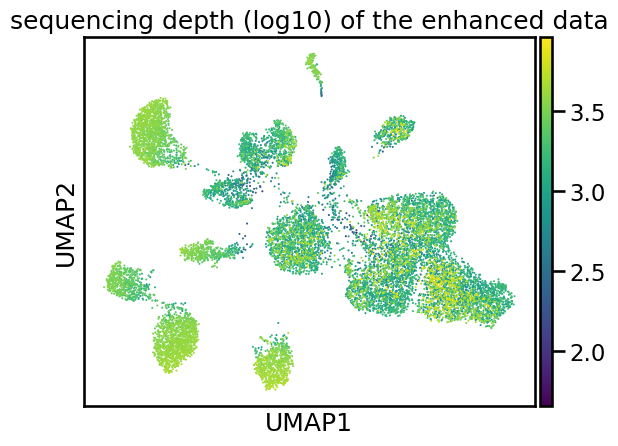

In [33]:
# UMAP visualizations of the enhanced MB dataset. Cells are colored by the sequencing depth of the enhanced MB dataset.
data = adata_en.copy()
epi.pp.binarize(data)
count_sum_per_cell = data.X.sum(axis=1)
data.obs['sequencing depth of the enhanced data'] = count_sum_per_cell
data.obs['sequencing depth (log10) of the enhanced data'] = np.log10(count_sum_per_cell)
sc.pl.umap(data, color=['sequencing depth (log10) of the enhanced data'],show=False,color_map='viridis')


# Heatmap of the count matrix of the raw MB dataset

Now we plot the Heatmap of the count matrix of the Fountain-enhanced dataset for the differentially accessible peaks (DAPs) identified from the raw MB dataset

In [34]:
from sklearn.preprocessing import Binarizer
adata0 = adata
def binarizer(count_matrix,threshold = 0):
    bn = Binarizer(threshold = threshold)
    count_matrix_bn = bn.fit_transform(count_matrix)
    return count_matrix_bn
adata0.X = binarizer(adata0.X)
sc.pp.normalize_total(adata0, inplace=True)
labelorder = adata0.obs["cell_type"].unique()
kwds={"standard_scale":"var"}

In [35]:
sc.tl.rank_genes_groups(adata0, groupby="cell_type", method="wilcoxon")
adata0.uns["rank_features_groups"]=adata0.uns["rank_genes_groups"]

In [36]:
plt.rcParams.update({'font.size': 12})
sc.tl.rank_genes_groups(adata0, groupby="cell_type", method="wilcoxon")
epi.tl.rank_features(adata0,'cell_type', omic='ATAC',use_raw=False,key_added='t-test')


Index(['Astro', 'Endo', 'L2/3 IT', 'Sst', 'Sncg', 'Pvalb', 'L4', 'Meis2',
       'L5 IT', 'L5 PT', 'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Macrophage', 'NP',
       'Oligo', 'Peri', 'VLMC', 'Vip'],
      dtype='object')


{'heatmap_ax': <Axes: >,
 'groupby_ax': <Axes: ylabel='cell_type'>,
 'gene_groups_ax': <Axes: >}

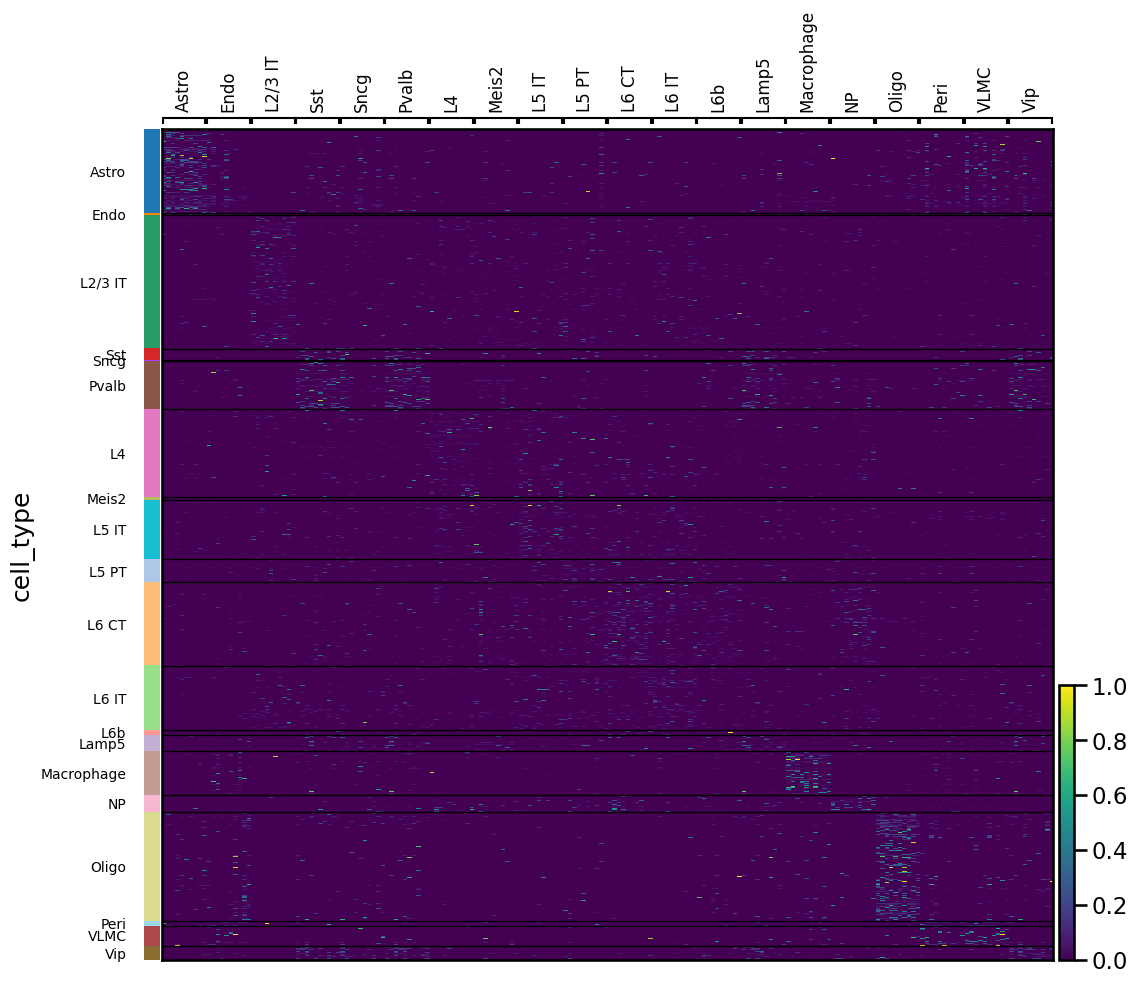

In [37]:
# In order to avoid text congestion between cell type names, we redefine the order of adata0.obs.cell_type
new_order =['Astro','Endo','L2/3 IT','Sst', 'Sncg','Pvalb','L4','Meis2','L5 IT','L5 PT','L6 CT','L6 IT','L6b','Lamp5','Macrophage',
    'NP','Oligo','Peri','VLMC','Vip']
adata0.obs['cell_type'] = pd.Categorical(adata0.obs['cell_type'], categories=new_order, ordered=True)
print(adata0.obs['cell_type'].cat.categories)

cell_types = new_order

result = adata0.uns['rank_features_groups']

names_array = result['names']
scores_array = result['scores']
pvals_array = result['pvals']
pvals_adj_array = result['pvals_adj']
logfoldchanges_array = result['logfoldchanges']

# Reorder each array
def reorder_recarray(recarray, new_order):  
    new_dtype = [(name, recarray.dtype[name]) for name in new_order]
    new_recarray = np.empty(recarray.shape, dtype=new_dtype)
    for name in new_order:
        new_recarray[name] = recarray[name]
    return new_recarray

result['names'] = reorder_recarray(names_array, new_order)
result['scores'] = reorder_recarray(scores_array, new_order)
result['pvals'] = reorder_recarray(pvals_array, new_order)
result['pvals_adj'] = reorder_recarray(pvals_adj_array, new_order)
result['logfoldchanges'] = reorder_recarray(logfoldchanges_array, new_order)
adata0.uns['rank_features_groups']=result
groups =cell_types
markers = pd.DataFrame(
    {group +  key[:1]: result[key][group]
    for group in groups for key in ['names']}).head(10).T
markers = np.array(markers.values).reshape(1,-1)[0]
sc.pl.heatmap(adata0, markers, groupby='cell_type',var_group_positions = [(0,9),(10,19),(20,29),(30,39),(40,49),(50,59),(60,69),(70,79),(80,89),(90,99),(100,109),(110,119),(120,129),(130,139),(140,149),(150,159),(160,169),(170,179),(180,189),(190,199)],var_group_labels = cell_types,standard_scale="var",figsize=(12, 11),show = False)


# Heatmap of the count matrix of the enhanced MB dataset

Next we plot the Heatmap of the count matrix of the Fountain-enhanced dataset for the differentially accessible peaks (DAPs) identified from the enhanced MB dataset

In [38]:
from sklearn.preprocessing import Binarizer
adata0 = adata_en
def binarizer(count_matrix,threshold = 0):
    bn = Binarizer(threshold = threshold)
    count_matrix_bn = bn.fit_transform(count_matrix)
    return count_matrix_bn
adata0.X = binarizer(adata0.X)
sc.pp.normalize_total(adata0, inplace=True)
labelorder = adata0.obs["cell_type"].unique()
kwds={"standard_scale":"var"}

In [39]:
sc.tl.rank_genes_groups(adata0, groupby="cell_type", method="wilcoxon")
adata0.uns["rank_features_groups"]=adata0.uns["rank_genes_groups"]

In [40]:
plt.rcParams.update({'font.size': 12})
sc.tl.rank_genes_groups(adata0, groupby="cell_type", method="wilcoxon")
epi.tl.rank_features(adata0,'cell_type', omic='ATAC',use_raw=False,key_added='t-test')


Index(['Astro', 'Endo', 'L2/3 IT', 'Sst', 'Sncg', 'Pvalb', 'L4', 'Meis2',
       'L5 IT', 'L5 PT', 'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Macrophage', 'NP',
       'Oligo', 'Peri', 'VLMC', 'Vip'],
      dtype='object')


{'heatmap_ax': <Axes: >,
 'groupby_ax': <Axes: ylabel='cell_type'>,
 'gene_groups_ax': <Axes: >}

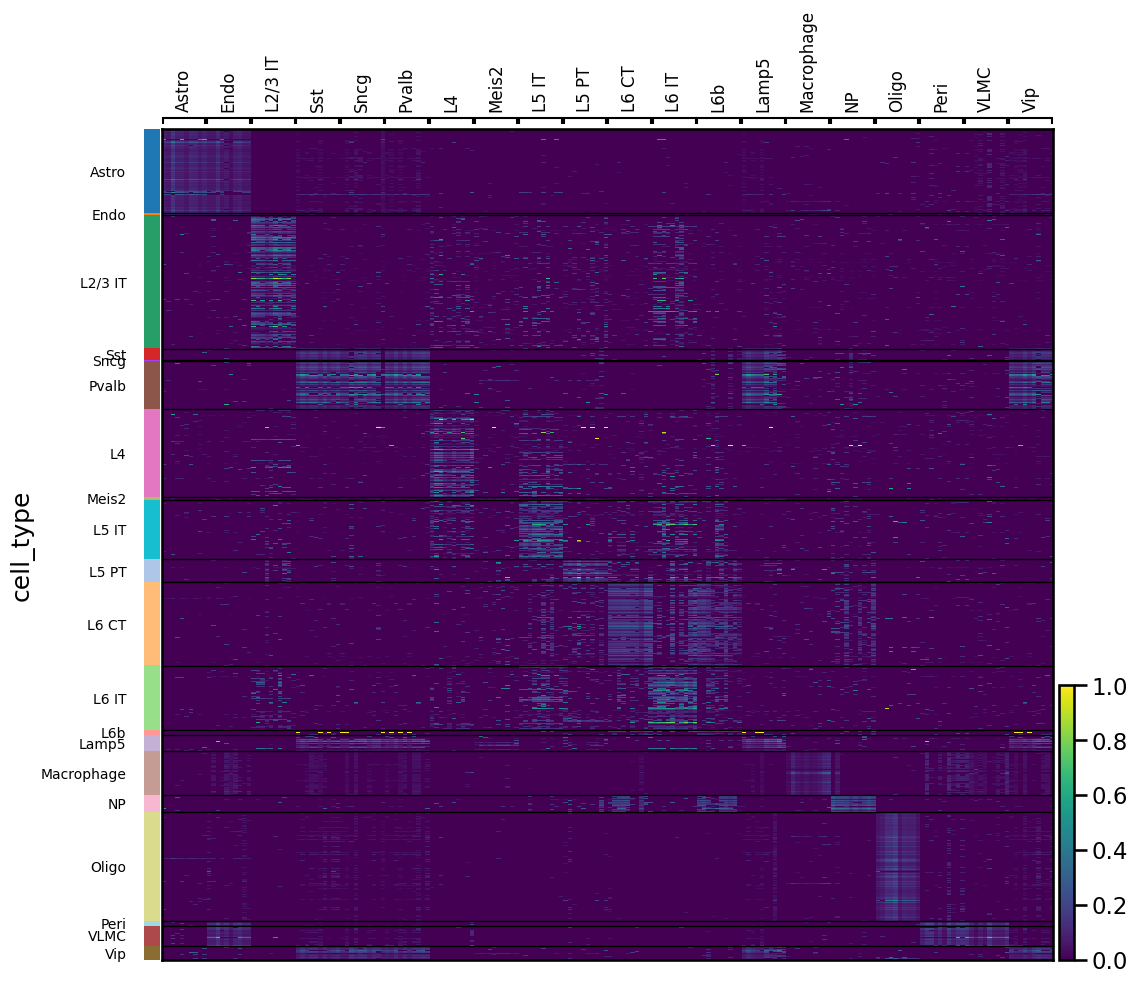

In [41]:
# In order to avoid text congestion between cell type names, we redefine the order of adata0.obs.cell_type
new_order =['Astro','Endo','L2/3 IT','Sst', 'Sncg','Pvalb','L4','Meis2','L5 IT','L5 PT','L6 CT','L6 IT','L6b','Lamp5','Macrophage',
    'NP','Oligo','Peri','VLMC','Vip']
adata0.obs['cell_type'] = pd.Categorical(adata0.obs['cell_type'], categories=new_order, ordered=True)
print(adata0.obs['cell_type'].cat.categories)



cell_types = new_order

result = adata0.uns['rank_features_groups']

names_array = result['names']
scores_array = result['scores']
pvals_array = result['pvals']
pvals_adj_array = result['pvals_adj']
logfoldchanges_array = result['logfoldchanges']


def reorder_recarray(recarray, new_order):  
    new_dtype = [(name, recarray.dtype[name]) for name in new_order]
    new_recarray = np.empty(recarray.shape, dtype=new_dtype)
    for name in new_order:
        new_recarray[name] = recarray[name]
    return new_recarray

result['names'] = reorder_recarray(names_array, new_order)
result['scores'] = reorder_recarray(scores_array, new_order)
result['pvals'] = reorder_recarray(pvals_array, new_order)
result['pvals_adj'] = reorder_recarray(pvals_adj_array, new_order)
result['logfoldchanges'] = reorder_recarray(logfoldchanges_array, new_order)
adata0.uns['rank_features_groups']=result
groups =cell_types
markers = pd.DataFrame(
    {group +  key[:1]: result[key][group]
    for group in groups for key in ['names']}).head(10).T
markers = np.array(markers.values).reshape(1,-1)[0]
sc.pl.heatmap(adata0, markers, groupby='cell_type',var_group_positions = [(0,9),(10,19),(20,29),(30,39),(40,49),(50,59),(60,69),(70,79),(80,89),(90,99),(100,109),(110,119),(120,129),(130,139),(140,149),(150,159),(160,169),(170,179),(180,189),(190,199)],var_group_labels = cell_types,standard_scale="var",figsize=(12, 11),show = False)


# Comparison of clustering performance

Fountain-enhanced data facilitates the characterization of cellular heterogeneity. For both the raw and Fountain-enhanced cell-by-peak matrix of the MB dataset, we utilized low-dimensional cell embeddings generated by term frequency-inverse document frequency (TF-IDF) transformation and PCA (50 dimensions) to evaluate clustering accuracy and batch integration. Next we provide different versions of TF-IDF transformation and users can pick one that they prefer.

In [42]:
import scipy
# Perform TF-IDF (count_mat: peak*cell)
def tfidf1(count_mat): 
    nfreqs = 1.0 * count_mat / np.tile(np.sum(count_mat,axis=0), (count_mat.shape[0],1))
    tfidf_mat = np.multiply(nfreqs, np.tile(np.log(1 + 1.0 * count_mat.shape[1] / np.sum(count_mat,axis=1)).reshape(-1,1), (1,count_mat.shape[1])))
    return scipy.sparse.csr_matrix(tfidf_mat)

# Perform Signac TF-IDF (count_mat: peak*cell)
def tfidf2(count_mat): 
    tf_mat = 1.0 * count_mat / np.tile(np.sum(count_mat,axis=0), (count_mat.shape[0],1))
    signac_mat = np.log(1 + np.multiply(1e4*tf_mat,  np.tile((1.0 * count_mat.shape[1] / np.sum(count_mat,axis=1)).reshape(-1,1), (1,count_mat.shape[1]))))
    return scipy.sparse.csr_matrix(signac_mat)

from sklearn.feature_extraction.text import TfidfTransformer
def tfidf3(count_mat): 
    model = TfidfTransformer(smooth_idf=False, norm="l2")
    model = model.fit(np.transpose(count_mat))
    model.idf_ -= 1
    tf_idf = np.transpose(model.transform(np.transpose(count_mat)))
    return scipy.sparse.csr_matrix(tf_idf)

## Enhanced data

In [47]:
adata_en1 = adata_en

tfidf_res = tfidf1(adata_en1.X.T).T
adata_en1.X = tfidf_res.copy()
sc.tl.pca(adata_en1)
sc.pp.neighbors(adata_en1, n_neighbors=15, use_rep="X_pca")
sc.tl.umap(adata_en1)
epi.tl.leiden(adata_en1, key_added='leiden')

AMI = cluster_evaluation(adata_en1.obs,'cell_type','leiden')[0]
ARI = cluster_evaluation(adata_en1.obs,'cell_type','leiden')[1]
NMI = cluster_evaluation(adata_en1.obs,'cell_type','leiden')[2]
Graph_connectivity = scib.me.graph_connectivity(adata_en1, label_key="cell_type")
ilisi_graph = scib.me.ilisi_graph(adata_en1, batch_key="batch",type_="embed",  use_rep="X_pca", scale=False)
overcorrection = overcorrection_score(adata_en1.obsm["X_pca"], adata_en1.obs['cell_type'], n_neighbors=100, n_pools=100, n_samples_per_pool=100)

Enhanced_score = [AMI,ARI,NMI,Graph_connectivity,ilisi_graph,overcorrection]
print(f"AMI:{AMI}, ARI:{ARI}, NMI{NMI}")
print(f"Graph_connectivity:{Graph_connectivity}, ilisi_graph:{ilisi_graph}, overcorrection:{overcorrection}")

leiden
leiden
leiden
AMI:0.7037041566423214, ARI:0.5264209384990507, NMI0.7054021027874289
Graph_connectivity:0.8818120722273324, ilisi_graph:1.209768114730467, overcorrection:0.19179588276642545


In [50]:
adata_en1 = adata_en

tfidf_res = tfidf2(adata_en1.X.T).T
adata_en1.X = tfidf_res.copy()
sc.tl.pca(adata_en1)
sc.pp.neighbors(adata_en1, n_neighbors=15, use_rep="X_pca")
sc.tl.umap(adata_en1)
epi.tl.leiden(adata_en1, key_added='leiden')

AMI = cluster_evaluation(adata_en1.obs,'cell_type','leiden')[0]
ARI = cluster_evaluation(adata_en1.obs,'cell_type','leiden')[1]
NMI = cluster_evaluation(adata_en1.obs,'cell_type','leiden')[2]
Graph_connectivity = scib.me.graph_connectivity(adata_en1, label_key="cell_type")
ilisi_graph = scib.me.ilisi_graph(adata_en1, batch_key="batch",type_="embed",  use_rep="X_pca", scale=False)
overcorrection = overcorrection_score(adata_en1.obsm["X_pca"], adata_en1.obs['cell_type'], n_neighbors=100, n_pools=100, n_samples_per_pool=100)

Enhanced_score2 = [AMI,ARI,NMI,Graph_connectivity,ilisi_graph,overcorrection]
print(f"AMI:{AMI}, ARI:{ARI}, NMI{NMI}")
print(f"Graph_connectivity:{Graph_connectivity}, ilisi_graph:{ilisi_graph}, overcorrection:{overcorrection}")

leiden
leiden
leiden
AMI:0.7179922883345132, ARI:0.5768094543869049, NMI0.7194965556477185
Graph_connectivity:0.8909629153892377, ilisi_graph:1.2004371519713748, overcorrection:0.21637137729800504


In [51]:
adata_en1 = adata_en

tfidf_res = tfidf3(adata_en1.X.T).T
adata_en1.X = tfidf_res.copy()
sc.tl.pca(adata_en1)
sc.pp.neighbors(adata_en1, n_neighbors=15, use_rep="X_pca")
sc.tl.umap(adata_en1)
epi.tl.leiden(adata_en1, key_added='leiden')

AMI = cluster_evaluation(adata_en1.obs,'cell_type','leiden')[0]
ARI = cluster_evaluation(adata_en1.obs,'cell_type','leiden')[1]
NMI = cluster_evaluation(adata_en1.obs,'cell_type','leiden')[2]
Graph_connectivity = scib.me.graph_connectivity(adata_en1, label_key="cell_type")
ilisi_graph = scib.me.ilisi_graph(adata_en1, batch_key="batch",type_="embed",  use_rep="X_pca", scale=False)
overcorrection = overcorrection_score(adata_en1.obsm["X_pca"], adata_en1.obs['cell_type'], n_neighbors=100, n_pools=100, n_samples_per_pool=100)

Enhanced_score3 = [AMI,ARI,NMI,Graph_connectivity,ilisi_graph,overcorrection]
print(f"AMI:{AMI}, ARI:{ARI}, NMI{NMI}")
print(f"Graph_connectivity:{Graph_connectivity}, ilisi_graph:{ilisi_graph}, overcorrection:{overcorrection}")

leiden
leiden
leiden
AMI:0.7143237237912433, ARI:0.5761526031078108, NMI0.715907084829294
Graph_connectivity:0.88863172712018, ilisi_graph:1.1714200904492187, overcorrection:0.20809505341042145


## Raw data

Fountain outputs enhanced-ATAC profiles with the same dimensionality as its input data. As the input data is binarized and filterd, so the same procedure should be used. The raw MB dataset can be download by click [here](https://drive.google.com/file/d/1qwKP1xzYVs5rEGRJPU_NJga2Gl0qSTv5/view?usp=drive_link).


In [49]:
adata1 = sc.read("mouse_brain_raw.h5ad")
binary=True
fpeak=0.04
if binary: epi.pp.binarize(adata1)
epi.pp.filter_features(adata1, min_cells=np.ceil(fpeak*adata1.shape[0]))
tfidf_res = tfidf1(adata1.X.T).T
adata1.X = tfidf_res.copy()

sc.tl.pca(adata1)
sc.pp.neighbors(adata1, n_neighbors=15, use_rep="X_pca")
sc.tl.umap(adata1)
epi.tl.leiden(adata1, key_added='leiden')
cluster_evaluation(adata1.obs,'cell_type','leiden')
AMI = cluster_evaluation(adata1.obs,'cell_type','leiden')[0]
ARI = cluster_evaluation(adata1.obs,'cell_type','leiden')[1]
NMI = cluster_evaluation(adata1.obs,'cell_type','leiden')[2]
Graph_connectivity = scib.me.graph_connectivity(adata1, label_key="cell_type")
ilisi_graph = scib.me.ilisi_graph(adata1, batch_key="batch",type_="embed",  use_rep="X_pca", scale=False)
overcorrection = overcorrection_score(adata1.obsm["X_pca"], adata1.obs['cell_type'], n_neighbors=100, n_pools=100, n_samples_per_pool=100)

Raw_score = [AMI,ARI,NMI,Graph_connectivity,ilisi_graph,overcorrection]
print(f"AMI:{AMI}, ARI:{ARI}, NMI{NMI}")
print(f"Graph_connectivity:{Graph_connectivity}, ilisi_graph:{ilisi_graph}, overcorrection:{overcorrection}")

leiden
leiden
leiden
leiden
AMI:0.678261628381399, ARI:0.5276825568703359, NMI0.6796718980691252
Graph_connectivity:0.8761314827046167, ilisi_graph:1.0521350522698456, overcorrection:0.2851167744981773


In [52]:
adata1 = sc.read("mouse_brain_raw.h5ad")
binary=True
fpeak=0.04
if binary: epi.pp.binarize(adata1)
epi.pp.filter_features(adata1, min_cells=np.ceil(fpeak*adata1.shape[0]))
tfidf_res = tfidf2(adata1.X.T).T
adata1.X = tfidf_res.copy()

sc.tl.pca(adata1)
sc.pp.neighbors(adata1, n_neighbors=15, use_rep="X_pca")
sc.tl.umap(adata1)
epi.tl.leiden(adata1, key_added='leiden')
cluster_evaluation(adata1.obs,'cell_type','leiden')
AMI = cluster_evaluation(adata1.obs,'cell_type','leiden')[0]
ARI = cluster_evaluation(adata1.obs,'cell_type','leiden')[1]
NMI = cluster_evaluation(adata1.obs,'cell_type','leiden')[2]
Graph_connectivity = scib.me.graph_connectivity(adata1, label_key="cell_type")
ilisi_graph = scib.me.ilisi_graph(adata1, batch_key="batch",type_="embed",  use_rep="X_pca", scale=False)
overcorrection = overcorrection_score(adata1.obsm["X_pca"], adata1.obs['cell_type'], n_neighbors=100, n_pools=100, n_samples_per_pool=100)

Raw_score2 = [AMI,ARI,NMI,Graph_connectivity,ilisi_graph,overcorrection]
print(f"AMI:{AMI}, ARI:{ARI}, NMI{NMI}")
print(f"Graph_connectivity:{Graph_connectivity}, ilisi_graph:{ilisi_graph}, overcorrection:{overcorrection}")

leiden
leiden
leiden
leiden
AMI:0.6737394963553394, ARI:0.4150392369107577, NMI0.6760821194794889
Graph_connectivity:0.8781604798336314, ilisi_graph:1.0212348515949725, overcorrection:0.22754310907012354


In [53]:
adata1 = sc.read("mouse_brain_raw.h5ad")
binary=True
fpeak=0.04
if binary: epi.pp.binarize(adata1)
epi.pp.filter_features(adata1, min_cells=np.ceil(fpeak*adata1.shape[0]))
tfidf_res = tfidf3(adata1.X.T).T
adata1.X = tfidf_res.copy()

sc.tl.pca(adata1)
sc.pp.neighbors(adata1, n_neighbors=15, use_rep="X_pca")
sc.tl.umap(adata1)
epi.tl.leiden(adata1, key_added='leiden')
cluster_evaluation(adata1.obs,'cell_type','leiden')
AMI = cluster_evaluation(adata1.obs,'cell_type','leiden')[0]
ARI = cluster_evaluation(adata1.obs,'cell_type','leiden')[1]
NMI = cluster_evaluation(adata1.obs,'cell_type','leiden')[2]
Graph_connectivity = scib.me.graph_connectivity(adata1, label_key="cell_type")
ilisi_graph = scib.me.ilisi_graph(adata1, batch_key="batch",type_="embed",  use_rep="X_pca", scale=False)
overcorrection = overcorrection_score(adata1.obsm["X_pca"], adata1.obs['cell_type'], n_neighbors=100, n_pools=100, n_samples_per_pool=100)

Raw_score3 = [AMI,ARI,NMI,Graph_connectivity,ilisi_graph,overcorrection]
print(f"AMI:{AMI}, ARI:{ARI}, NMI{NMI}")
print(f"Graph_connectivity:{Graph_connectivity}, ilisi_graph:{ilisi_graph}, overcorrection:{overcorrection}")

leiden
leiden
leiden
leiden
AMI:0.6871328017840467, ARI:0.46891085876243466, NMI0.6892676439983031
Graph_connectivity:0.8286464867737525, ilisi_graph:1.0231911123414201, overcorrection:0.22251522669261803


## Visualization

Here we take the results processed by TF-IDF1 transformation. Different versions of TF-IDF transformation will result in similar results.

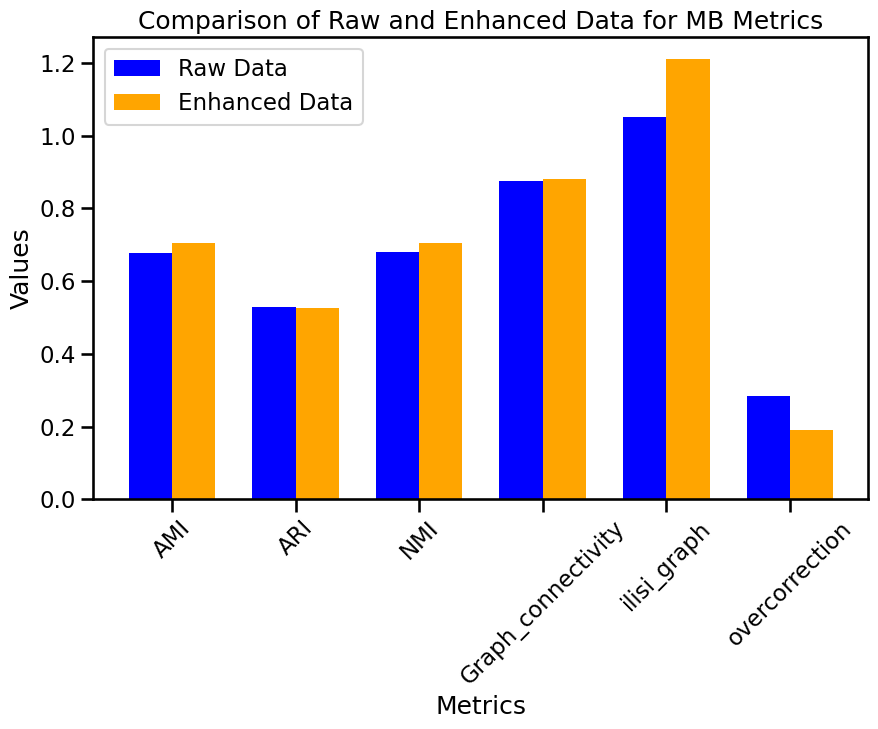

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Creating the data
data = {
    "Metric": ["AMI", "ARI", "NMI", "Graph_connectivity", "ilisi_graph", "overcorrection"],
    "Raw Data": Raw_score,
    "Enhanced Data": Enhanced_score,
}

# Converting the data into a DataFrame
df = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(df['Metric']))
width = 0.35

bars1 = ax.bar(x - width/2, df['Raw Data'], width, label='Raw Data', color='blue')
bars2 = ax.bar(x + width/2, df['Enhanced Data'], width, label='Enhanced Data', color='orange')

# Adding labels, title and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Raw and Enhanced Data for MB Metrics')
ax.set_xticks(x)
ax.set_xticklabels(df['Metric'])
ax.legend()

# Rotating the tick labels for better visibility
plt.xticks(rotation=45)
# Show the plot
plt.show()


# Annotation performance

To further validate that data enhanced by Fountain improves cell type annotation accuracy, we performed
five-fold cross-validation experiments. We use four widely adopted machine learning models—support vector machine (SVM), random forest (RF), k-nearest neighbors (kNN), and Gaussian naive Bayes (GNB)—for cell type annotation. And we evaluate annotation performance using Cohen’s kappa value (κ), median F1 score (mF1), and Accuracy metrics.
The preprocess is same with the clustering procedure.

In [68]:
adata1 = sc.read("mouse_brain_raw.h5ad")
binary=True
fpeak=0.04
if binary: epi.pp.binarize(adata1)
epi.pp.filter_features(adata1, min_cells=np.ceil(fpeak*adata1.shape[0]))
tfidf_res = tfidf1(adata1.X.T).T
adata1.X = tfidf_res.copy()

tfidf_res = tfidf1(adata_en.X.T).T
adata_en.X = tfidf_res.copy()

In [ ]:
X = adata1.X.toarray()  # raw data
y = adata1.obs['cell_type'].values  # labels

X1 = adata_en.X.toarray()  # enhanced data
results ={}
# 
models = {
    'GNB': GaussianNB(),  
    'SVM': SVC(),  
    'RandomForest': RandomForestClassifier(), 
    'kNN': KNeighborsClassifier()  
}

# 5-fold corss-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    # Initialize lists to store the true labels and predicted labels after 5 fold
    all_true_labels_X = []
    all_pred_labels_X = []
    
    all_true_labels_X1 = []
    all_pred_labels_X1 = []

    # Initialize model result storage
    results[model_name] = {
        'accuracies_raw': [],
        'kappas_raw': [],
        'f1_scores_raw': [],
        'accuracies_en': [],
        'kappas_en': [],
        'f1_scores_en': []
    }
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Training and evaluating the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        all_true_labels_X.extend(y_test)
        all_pred_labels_X.extend(y_pred)
        
        results[model_name]['accuracies_raw'].append(accuracy_score(y_test, y_pred))
        results[model_name]['kappas_raw'].append(cohen_kappa_score(y_test, y_pred))
        results[model_name]['f1_scores_raw'].append(f1_score(y_test, y_pred, average='weighted'))
        print(f"The original data is completed on one of the folds of {model_name}")
        
        
        model.fit(X1[train_index], y_train)  
        y_pred = model.predict(X1[test_index])  
        all_true_labels_X1.extend(y_test)
        all_pred_labels_X1.extend(y_pred)

        results[model_name]['accuracies_en'].append(accuracy_score(y_test, y_pred))
        results[model_name]['kappas_en'].append(cohen_kappa_score(y_test, y_pred))
        results[model_name]['f1_scores_en'].append(f1_score(y_test, y_pred, average='weighted'))
        print(f"The enhanced data is completed on one of the folds of {model_name}")
        
for model_name in models.keys():
    print(f'{model_name} The average accuracy of five-fold cross validation on raw data: {np.mean(results[model_name]["accuracies_raw"]):.4f}')
    print(f'{model_name} The average kappa of five-fold cross validation on raw data: {np.mean(results[model_name]["kappas_raw"]):.4f}')
    print(f'{model_name} The average mF1 of five-fold cross validation on raw data:{np.mean(results[model_name]["f1_scores_raw"]):.4f}')
    print(f'{model_name} The average accuracy of five-fold cross validation on enhanced data: {np.mean(results[model_name]["accuracies_en"]):.4f}')
    print(f'{model_name} The average kappa of five-fold cross validation on enhanced data: {np.mean(results[model_name]["kappas_en"]):.4f}')
    print(f'{model_name} The average mF1 of five-fold cross validation on enhanced data: {np.mean(results[model_name]["f1_scores_en"]):.4f}')



The original data is completed on one of the folds of GNB
The enhanced data is completed on one of the folds of GNB
The original data is completed on one of the folds of GNB
The enhanced data is completed on one of the folds of GNB
The original data is completed on one of the folds of GNB
The enhanced data is completed on one of the folds of GNB
The original data is completed on one of the folds of GNB
The enhanced data is completed on one of the folds of GNB
The original data is completed on one of the folds of GNB
The enhanced data is completed on one of the folds of GNB
